# Monostatic radar cross section (RCS) of a PEC sphere

Monostatic RCS measures the power of an electromagnetic wave reflected directly back to the radar source (transmitter and receiver are co-located). Mathematically, it is defined as:

$$
\sigma = \lim_{R \to \infty} 4\pi R^2 \frac{|\mathbf{E}_{\text{scattered}}|^2}{|\mathbf{E}_{\text{incident}}|^2} 
$$

where:
- $ R $  : Distance between the radar and target.
- $ \mathbf{E}_{\text{scattered}} $ : Electric field of the scattered wave.
- $ \mathbf{E}_{\text{incident}} $  : Electric field of the incident wave.

In this notebook, we aim to benchmark the accuracy of Tidy3D by simulating the monostatic RCS of a PEC sphere and compare the results to the well-known analytical solution based on Mie theory. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Simulation Setup

The monostatic RCS calculation for a PEC sphere is a classic problem in electromagnetics. The RCS is usually normalized by the physical cross section area of the sphere $\pi r^2$, where $r$ is the radius. Our goal is to calculate the normalized RCS as a function of the unitless relative frequency $2 \pi r/\lambda_0$. 

In this particular case, we will calculate the RCS for a relative frequency range from 1 to 10. The result will be plotted in a log scale so the frequency points are generated in a log scale here.

In [2]:
r = 1  # radius of the sphere
rel_freqs = np.logspace(0, 1, 201)  # relative frequency in log scale
ldas = 2 * np.pi * r / rel_freqs  # wavelength range
freqs = td.C_0 / ldas  # frequency range

freq0 = (freqs[-1] + freqs[0]) / 2  # central frequency for the source
fwidth = (freqs[-1] - freqs[0]) / 2  # frequency width for the source

Create the PEC sphere.

In [3]:
sphere = td.Structure(geometry=td.Sphere(radius=r), medium=td.PECMedium())

Next, we define a [TFSF](https://www.flexcompute.com/tidy3d/examples/notebooks/TFSF/) source as the excitation. For RCS calculation, the [TFSF](https://www.flexcompute.com/tidy3d/examples/notebooks/TFSF/) source is the most suitable since it injects a plane wave with unit power density, which makes the normalization of the RCS calculation automatic. The source needs to enclose the sphere. The incident angle and direction do not matter due to the symmetry of the sphere but we have it injected in the $z$ axis in this case.

In [4]:
source_size = 3 * r

source = td.TFSF(
    size=[source_size] * 3,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    injection_axis=2,
    direction="-",
)

The RCS calculation is automatically done in a [FieldProjectionAngleMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldProjectionAngleMonitor.html). The monitor needs to enclose both the source and the sphere. Since we are only interested in the monostatic RCS, we only need to project to one particular angle, namely the opposite direction of the incident direction. 

In [5]:
monitor_size = 4 * r

monitor = td.FieldProjectionAngleMonitor(
    size=[monitor_size] * 3,
    freqs=freqs,
    name="far_field",
    phi=[0],
    theta=[0],
)

Put everything into a [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) instance. Here we use a uniform grid of size $r$/100 to sufficiently resolve the curved surface of the sphere. By default, we apply a subpixel averaging method known as the conformal mesh scheme to PEC boundaries.

The automatic shutoff level by default is at `1e-5`. Here to further push the accuracy, we lower it to `1e-8`.

In [6]:
run_time = 1e-13
sim_size = 6 * r

sim = td.Simulation(
    size=[sim_size] * 3,
    grid_spec=td.GridSpec.uniform(dl=r / 100),
    structures=[sphere],
    sources=[source],
    monitors=[monitor],
    run_time=run_time,
    shutoff=1e-8,
)

Visualize the simulation to ensure the setup is correct.

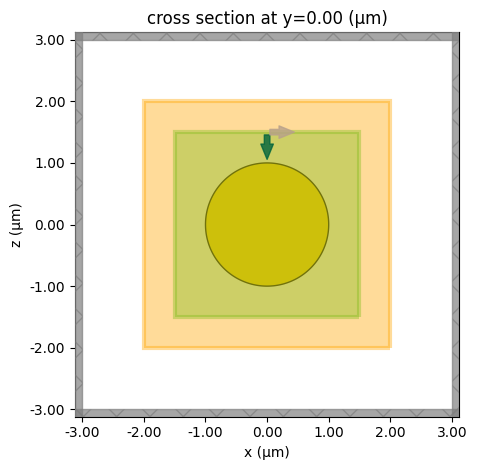

In [7]:
sim.plot(y=0)
plt.show()

## Submit the Simulation to the Server

Once we confirm that the simulation is set up properly, we can run it.

In [8]:
sim_data = web.run(simulation=sim, task_name="pec_sphere_rcs")

14:41:26 CEST Created task 'pec_sphere_rcs' with task_id                        
              'fdve-5b87798a-dd38-426e-9e3a-ec376bb6b19a' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=140781;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b87798a-dd38-426e-9e3a-ec376bb6b19a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=408431;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b87798a-dd38-426e-9e3a-ec376bb6b19a\taskId]8;;\]8;id=140781;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b87798a-dd38-426e-9e3a-ec376bb6b19a\=]8;;\]8;id=506818;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b87798a-dd38-426e-9e3a-ec376bb6b19a\fdve]8;;\]8;id=140781;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b87798a-dd38-426e-9e3a-ec376bb6b19a\-5b87798a-dd]8;;\
              ]8;id=140781;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b87798a-dd38-426e-9e3a-ec376bb6b19a\38-426e-9e3a-ec376bb6b19a']8;;\.

              Task folder: ]8;id=491246;https://tidy3d.simulation.cloud/folders/9b36e144-ddb6-41f8-8dd8-30b62b26a870\'default']8;;\.

Output()

14:41:30 CEST Maximum FlexCredit cost: 0.595. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

14:41:32 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

14:41:46 CEST status = preprocess

14:41:51 CEST starting up solver

              running solver

Output()

14:42:36 CEST early shutoff detected at 64%, exiting.

              status = success

              View simulation result at                                         
              ]8;id=457539;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b87798a-dd38-426e-9e3a-ec376bb6b19a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=865135;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b87798a-dd38-426e-9e3a-ec376bb6b19a\taskId]8;;\]8;id=457539;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b87798a-dd38-426e-9e3a-ec376bb6b19a\=]8;;\]8;id=99344;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b87798a-dd38-426e-9e3a-ec376bb6b19a\fdve]8;;\]8;id=457539;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b87798a-dd38-426e-9e3a-ec376bb6b19a\-5b87798a-dd]8;;\
              ]8;id=457539;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b87798a-dd38-426e-9e3a-ec376bb6b19a\38-426e-9e3a-ec376bb6b19a']8;;\.

Output()

14:42:38 CEST loading simulation from simulation_data.hdf5

## Postprocessing and Visualization

Once the simulation is complete, we can calculate the RCS directly from the monitor data and normalize it to the physical cross section of the sphere.

In [9]:
rcs_tidy3d = sim_data["far_field"].radar_cross_section.real.squeeze(drop=True).values / (
    np.pi * r**2
)

The normalized monostatic RCS (σ/πr²) of a PEC sphere is calculated using the Mie series solution:

$$
\frac{\sigma}{\pi r^2} = \frac{4}{x^2} \left| \sum_{n=1}^\infty (-1)^n (n + 0.5) \left(a_n - b_n \right) \right|^2 ,
$$

where:

- Relative frequency:  
  $$ x = \frac{2\pi r}{\lambda} \quad \text{(unitless)} $$
- Mie coefficients: 
    $$ a_n = -\frac{\left[x j_n(x)\right]'}{\left[x h_n^{(1)}(x)\right]'} $$  
    $$ b_n = -\frac{j_n(x)}{h_n^{(1)}(x)} $$

- Spherical Bessel function: $$ j_n(x) $$
- Spherical Hankel function (1st kind):  
    $$ h_n^{(1)}(x) = j_n(x) + i y_n(x) $$

We calculate the RCS according to the formula above and compare it to the simulated RCS from Tidy3D.

In [10]:
from scipy.special import spherical_jn, spherical_yn


def normalized_rcs(rel_freq):
    """
    Calculate the monostatic RCS of a PEC sphere normalized by πr².

    Parameters:
    relative_frequency (float): The relative frequency (2πr/λ), unitless.

    Returns:
    float: Normalized RCS (σ / πr²), unitless.
    """

    if rel_freq <= 0:
        return 0.0

    # determine the maximum number of terms in the series
    N_max = int(np.floor(rel_freq + 4 * rel_freq ** (1 / 3) + 2))
    total_sum = 0.0j

    for n in range(1, N_max + 1):
        # compute spherical Bessel (jn) and Neumann (yn) functions
        jn = spherical_jn(n, rel_freq)  # j_n(x)
        jn_deriv = spherical_jn(n, rel_freq, True)  # j_n'(x)

        yn = spherical_yn(n, rel_freq)  # y_n(x)
        yn_deriv = spherical_yn(n, rel_freq, True)  # y_n'(x)

        # spherical Hankel function of the first kind (hn1)
        hn1 = jn + 1j * yn  # h_n^(1)(x)
        hn1_deriv = jn_deriv + 1j * yn_deriv  # [h_n^(1)]'(x)

        # calculate (x * jn)' and (x * hn1)'
        x_jn_deriv = jn + rel_freq * jn_deriv
        x_hn1_deriv = hn1 + rel_freq * hn1_deriv

        # Mie coefficients for PEC sphere
        a_n = -x_jn_deriv / x_hn1_deriv
        b_n = -jn / hn1

        # series term
        term = ((-1) ** n) * (n + 0.5) * (a_n - b_n)
        total_sum += term

    # compute the normalized RCS
    if rel_freq == 0:
        return 0.0
    rcs_normalized = (4.0 / rel_freq**2) * (np.abs(total_sum) ** 2)
    return rcs_normalized.real


rcs_analytic = [normalized_rcs(rel_freq) for rel_freq in rel_freqs]

Plot the simulated and calculated RCS together. The results overlap very well, indicating the good accuracy of the Tidy3D solver.

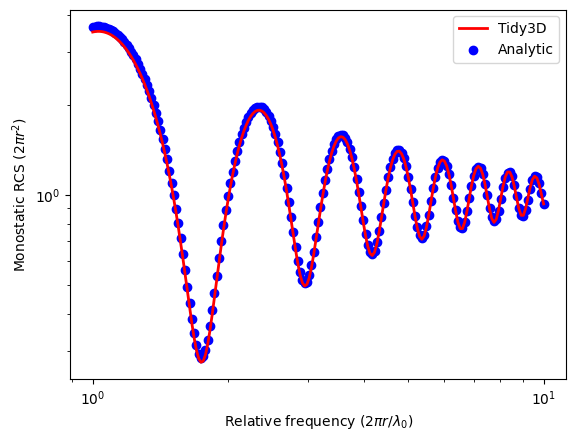

In [11]:
plt.plot(rel_freqs, rcs_tidy3d, "red", linewidth=2, label="Tidy3D")
plt.scatter(rel_freqs, rcs_analytic, c="blue", label="Analytic")
plt.xlabel(r"Relative frequency (2$\pi r$/$\lambda_0$)")
plt.ylabel(r"Monostatic RCS (2$\pi r^2$)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()